In [1]:
""" Install the required libraries: transformers, torchvision, and PIL"""

!pip install -q transformers torchvision ftfy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00


In [2]:
""" Import CLIP model, processor, and helper libraries"""

from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt


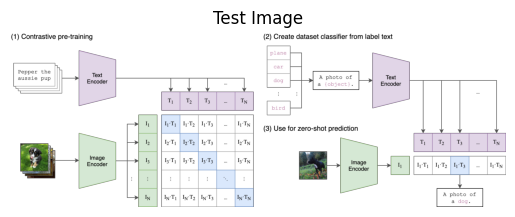

In [3]:
""" Load an image either from a URL or local path"""

image_url = "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"
image = Image.open(requests.get(image_url, stream=True).raw)
plt.imshow(image)
plt.axis("off")
plt.title("Test Image")
plt.show()


In [4]:
""" Define class names/prompts for zero-shot comparison"""

# You can change these based on the context you want
class_names = ["a diagram", "a dog", "a cat", "a person", "a screenshot", "an object", "a car"]


In [5]:
""" Encode image and text inputs with CLIP and compute similarity"""

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = processor(text=class_names, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

logits_per_image = outputs.logits_per_image  # Shape: [1, N_classes]
probs = logits_per_image.softmax(dim=1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

🏷️ Predicted label: a diagram


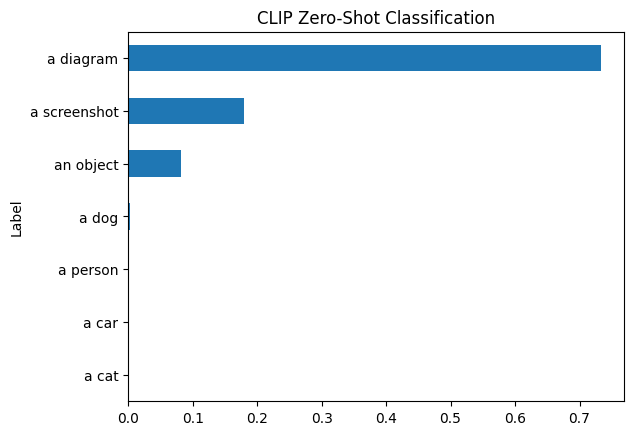

In [6]:
""" Display class probabilities and most likely prediction"""

import pandas as pd

probs = probs[0].detach().numpy()
results_df = pd.DataFrame({
    "Label": class_names,
    "Probability": probs
}).sort_values(by="Probability", ascending=False)

print("🏷️ Predicted label:", results_df.iloc[0]["Label"])
results_df.plot(kind="barh", x="Label", y="Probability", title="CLIP Zero-Shot Classification", legend=False)
plt.gca().invert_yaxis()
plt.show()


Transfer Learning using BigTransfer (BiT)

In [7]:
""" Install TensorFlow Hub and TensorFlow Datasets"""

!pip install -q tensorflow tensorflow-hub tensorflow-datasets


In [8]:
""" Import all necessary modules"""

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [9]:
""" Load and preprocess the TensorFlow Flowers dataset"""

def format_example(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

train_ds = train_ds.map(format_example).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(32).prefetch(tf.data.AUTOTUNE)

num_classes = ds_info.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.FPES55_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [10]:
"""🔗 Load BigTransfer model from TensorFlow Hub as a feature extractor"""

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
feature_extractor_layer = hub.KerasLayer(bit_model_url, input_shape=(224, 224, 3), trainable=False)


In [12]:
""" Build a Keras model using the BiT feature extractor"""
import tensorflow as tf
import tensorflow_hub as hub

# Wrap the hub.KerasLayer in a tf.keras.layers.Layer
# This ensures compatibility with tf.keras.Sequential
class BiTFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, bit_model_url):
        super(BiTFeatureExtractor, self).__init__()
        self.bit_model = hub.KerasLayer(bit_model_url, trainable=False)

    def call(self, inputs):
        return self.bit_model(inputs)

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
feature_extractor = BiTFeatureExtractor(bit_model_url)

model = tf.keras.Sequential([
    feature_extractor, # Use the wrapped feature extractor
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
"""⚙️ Compile and train the model"""

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1044s 11s/step - accuracy: 0.8083 - loss: 0.9640 - val_accuracy: 0.9346 - val_loss: 0.1747
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1027s 11s/step - accuracy: 0.9502 - loss: 0.1349 - val_accuracy: 0.9659 - val_loss: 0.1101
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1099s 12s/step - accuracy: 0.9726 - loss: 0.0918 - val_accuracy: 0.9605 - val_loss: 0.1208
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1086s 12s/step - accuracy: 0.9741 - loss: 0.0665 - val_accuracy: 0.9687 - val_loss: 0.1233
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1103s 12s/step - accuracy: 0.9793 - loss: 0.0649 - val_accuracy: 0.9741 - val_loss: 0.0973


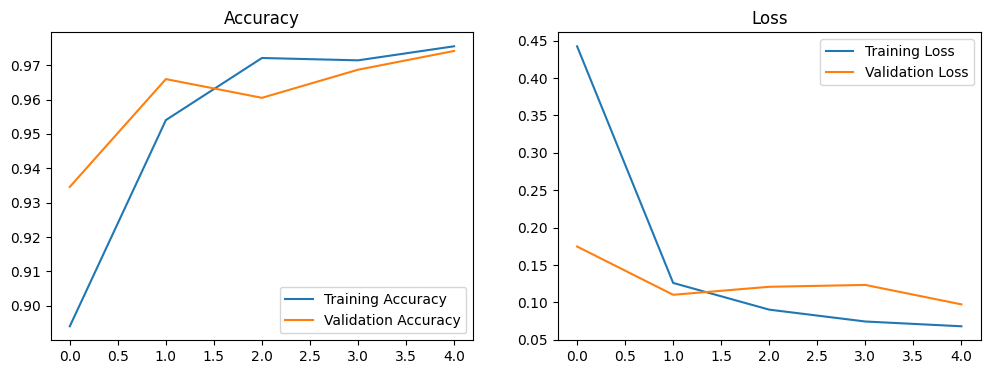

In [14]:
"""📊 Plot training and validation accuracy/loss"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()
